In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import re
import string
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from sklearn.metrics import confusion_matrix, f1_score
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import gensim
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases
import nltk
from nltk.collections import *
from nltk import FreqDist, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from transformers import pipeline
import pyLDAvis
import pyLDAvis.gensim
from wordcloud import WordCloud
plt.rcParams['figure.dpi'] = 300
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
%matplotlib inline

In [845]:
cs = pd.read_csv('delighted-data_4-March-2021.csv', usecols=[1, 3, 4, 5, 12])
cs = cs[['Response Timestamp', 'Name', 'Score', 'Comment', 'additional feedback ']]
cs.columns = ['date', 'Name', 'rating', 'Comment', 'Additional']
cs.date = pd.to_datetime(cs.date)
cs.head()

,date,Name,rating,Comment,Additional
0,2021-03-04 14:52:00,Lillian Boyd,4,NaN,NaN
1,2021-03-04 14:42:00,Evelyn McGovern,5,NaN,NaN
2,2021-03-04 13:43:00,Angela Rowe,3,"i prefer to speak to a person,Especially when ...",NaN
3,2021-03-04 13:32:00,Phyllis,5,Knowledgeable and professional,NaN
4,2021-03-04 12:56:00,Patricia Brown,3,I cancelled Petplan so this does not apply to ...,NaN


In [846]:
cs['Comment'] = cs.Comment.str.replace('[\n\t]', "", regex = True)
cs['Additional'] = cs.Additional.str.replace('[\n\t]', "", regex = True)
# cs.Comment = cs.Comment.astype('str')
cs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1422 non-null   datetime64[ns]
 1   Name        1422 non-null   object        
 2   rating      1422 non-null   int64         
 3   Comment     743 non-null    object        
 4   Additional  303 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 55.7+ KB


In [847]:
cs['reviews'] = cs.apply(lambda x: x['Comment'] + ' ' + x['Additional'] if (pd.notna(x['Comment']) and pd.notna(x['Additional'])) else x['Comment'] if pd.notna(x['Comment']) else None, axis = 1)
cs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        1422 non-null   datetime64[ns]
 1   Name        1422 non-null   object        
 2   rating      1422 non-null   int64         
 3   Comment     743 non-null    object        
 4   Additional  303 non-null    object        
 5   reviews     743 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 66.8+ KB


In [848]:
cs.drop(['Comment', 'Additional'], inplace=True, axis=1)
cs.columns=['date', 'userName', 'rating', 'reviews']
cs = cs[cs.reviews.notna()]
cs.head()

,date,userName,rating,reviews
2,2021-03-04 13:43:00,Angela Rowe,3,"i prefer to speak to a person,Especially when ..."
3,2021-03-04 13:32:00,Phyllis,5,Knowledgeable and professional
4,2021-03-04 12:56:00,Patricia Brown,3,I cancelled Petplan so this does not apply to ...
6,2021-03-04 12:37:00,Staci,1,"I called on Monday, and my issue has still not..."
7,2021-03-04 12:27:00,Shawn,3,i was charged when i wasnt supposed to\r


In [849]:
df2=pd.read_csv('petplan_ios_review_2020.csv', index_col=0)
df2 = df2[['date', 'userName', 'rating', 'review']]
df2.columns = ['date', 'userName', 'rating', 'reviews']
df2 = df2[:1890]
df2

,date,userName,rating,reviews
0,2021-02-04 19:28:53,julian8000,2,I have never left a review of an app before bu...
1,2021-02-01 06:00:43,ks2dogs,1,As a client for almost 10 years ensuring two p...
2,2021-01-22 22:45:24,Gumpy3,1,Seriously?!?! You have been sending me emails ...
3,2021-02-13 02:39:51,hurolope,1,I’m not sure who designed and approved this ap...
4,2020-12-18 20:18:41,Pigglette69,4,"New App is a joke. Loose the Leo interface, i..."
...,...,...,...,...
1885,2020-03-03 23:15:18,you can't fix it,1,It’s fine when it works but it’s down 99.99% o...
1886,2021-01-19 07:12:49,Mega Aaron,1,The app is literally useless. It has not worke...
1887,2021-01-15 18:15:15,Climbmnts,1,Signed my Kitten up today but the website and ...
1888,2020-10-13 15:42:25,everkath,1,"PetPlan has been a great insurance company, an..."


In [850]:
df_nodup = df.drop_duplicates(keep='first', ignore_index=True)
df_nodup

,date,userName,rating,reviews,textblob_score,textblob_label,rating_label,transformer_rating,transformer_label,transformer_label_sentence,day
0,2021-02-04 19:28:00,julian8000,2,I have never left a review of an app before bu...,0.0,Neutral,Negative,1,Negative,[{'I have never left a review of an app before...,2021-02-04
1,2021-02-01 06:00:00,ks2dogs,1,As a client for almost 10 years ensuring two p...,0.0,Neutral,Negative,1,Negative,[{'As a client for almost 10 years ensuring tw...,2021-02-01
2,2021-01-22 22:45:00,Gumpy3,1,Seriously?!?! You have been sending me emails ...,0.2,Positive,Negative,1,Negative,[{'Seriously?!?! You have been sending me emai...,2021-01-22
3,2021-02-13 02:39:00,hurolope,1,I’m not sure who designed and approved this ap...,-0.1,Negative,Negative,2,Negative,[{'I’m not sure who designed and approved this...,2021-02-13
4,2020-12-18 20:18:00,Pigglette69,4,"New App is a joke. Loose the Leo interface, i...",0.0,Neutral,Positive,1,Negative,"[{'New App is a joke.': 'Negative', 'Loose the...",2020-12-18
...,...,...,...,...,...,...,...,...,...,...,...
798,2021-02-26 15:09:00,Asaf,3,It’s the second time that I had trouble until ...,0.0,Neutral,Neutral,1,Negative,[{'It’s the second time that I had trouble unt...,2021-02-26
799,2021-02-26 15:08:00,Debra,5,Always helpful and caring!,0.0,Neutral,Positive,5,Positive,[{'Always helpful and caring!': 'Positive'}],2021-02-26
800,2021-02-26 15:06:00,Tod,1,My experience with your new website has been d...,-0.2,Negative,Negative,1,Negative,[{'My experience with your new website has bee...,2021-02-26
801,2021-02-26 15:06:00,Cristina,1,Because you guys keep messing with the app and...,0.0,Neutral,Negative,1,Negative,[{'Because you guys keep messing with the app'...,2021-02-26


In [851]:
df = pd.concat([df2, cs], ignore_index=True)
df

,date,userName,rating,reviews
0,2021-02-04 19:28:53,julian8000,2,I have never left a review of an app before bu...
1,2021-02-01 06:00:43,ks2dogs,1,As a client for almost 10 years ensuring two p...
2,2021-01-22 22:45:24,Gumpy3,1,Seriously?!?! You have been sending me emails ...
3,2021-02-13 02:39:51,hurolope,1,I’m not sure who designed and approved this ap...
4,2020-12-18 20:18:41,Pigglette69,4,"New App is a joke. Loose the Leo interface, i..."
...,...,...,...,...
2628,2021-02-26 15:06:00,Tod,1,My experience with your new website has been d...
2629,2021-02-26 15:06:00,Cristina,1,Because you guys keep messing with the app and...
2630,2021-02-26 15:05:00,Kristal,5,Excellent service
2631,2021-02-26 15:02:00,Janet,1,The nes website is extremely limited in useful...


In [854]:
df.date = pd.to_datetime(df.date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2633 entries, 0 to 2632
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      2633 non-null   datetime64[ns]
 1   userName  2633 non-null   object        
 2   rating    2633 non-null   int64         
 3   reviews   2633 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 82.4+ KB


(0.0, 100.0)

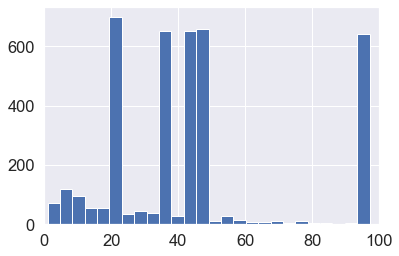

In [506]:
df.reviews.str.split().str.len().hist(bins = 100, )
plt.xlim(0, 100)

In [540]:
df = df[df.reviews.str.split().str.len()>3]
df.reviews = df.reviews.str.replace('[\n\t]', "", regex = True)
# df.Comment = df.Comment.astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2595 entries, 0 to 2631
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      2595 non-null   object
 1   userName  2595 non-null   object
 2   rating    2595 non-null   int64 
 3   reviews   2595 non-null   object
dtypes: int64(1), object(3)
memory usage: 101.4+ KB


In [861]:
class text_blob_score(object):
      
    def __init__(self):
        self.nlp = spacy.load("en_core_web_sm")
        self.spacy_text_blob = SpacyTextBlob()
        self.nlp.add_pipe(self.spacy_text_blob)
    
    def score_by_sentence(self, text):
        self.text = text
        self.sent_score = {}
        sentences = self.nlp(self.text)
        sents = [str(s).strip().lower() for s in sentences.sents]
        for i in sents:
            doc = self.nlp(i)
            self.sent_score[i] = doc._.sentiment.polarity
        return self.sent_score
    def score_mean_textblob(self, text):
        x = [i for i in self.score_by_sentence(text).values() if i!=0]
        return np.mean(x)
    def score_by_review(self, review):
        review = self.nlp(review)
        return review._.sentiment.polarity

In [ ]:
classifier = text_blob_score()


In [541]:
classifier = text_blob_score()
df['textblob_score'] =  df.reviews.apply(lambda x: round(classifier.score_by_review(x),1))

In [542]:
df['textblob_label'] = df.textblob_score.apply(lambda x: 'Negative' if x < 0 else 'Neutral' if x==0 else 'Positive')

In [543]:
label = {1:'Negative', 2: 'Negative', 3: 'Neutral', 4: 'Positive', 5: 'Positive'}
df['rating_label'] = df.rating.apply(lambda x: label[x] if pd.notna(x) else None)
df

,date,userName,rating,reviews,textblob_score,textblob_label,rating_label
0,2021-02-04 19:28:53,julian8000,2,I have never left a review of an app before bu...,-0.0,Neutral,Negative
1,2021-02-01 06:00:43,ks2dogs,1,As a client for almost 10 years ensuring two p...,0.0,Neutral,Negative
2,2021-01-22 22:45:24,Gumpy3,1,Seriously?!?! You have been sending me emails ...,0.2,Positive,Negative
3,2021-02-13 02:39:51,hurolope,1,I’m not sure who designed and approved this ap...,-0.1,Negative,Negative
4,2020-12-18 20:18:41,Pigglette69,4,"New App is a joke. Loose the Leo interface, i...",0.0,Neutral,Positive
...,...,...,...,...,...,...,...
2626,2021-02-26 15:09:00,Asaf,3,It’s the second time that I had trouble until ...,0.0,Neutral,Neutral
2627,2021-02-26 15:08:00,Debra,5,Always helpful and caring!,0.0,Neutral,Positive
2628,2021-02-26 15:06:00,Tod,1,My experience with your new website has been d...,-0.2,Negative,Negative
2629,2021-02-26 15:06:00,Cristina,1,Because you guys keep messing with the app and...,0.0,Neutral,Negative


In [544]:
df.iloc[4,:].reviews

'New App is a joke.  Loose the Leo interface, it annoying and usually covering something useful.  Half the features don’t work, like updating your pet’s info.  You can fill it in and pick a photo from your library, but it doesn’t load the photo or save the information.  The original App worked just fine on a iPad even in landscape mode.  The last Version wouldn’t work at all and the response was use a iPhone, computer, or phone.  This one works somewhat, and if it somehow pops into landscape you can’t see the bottom.  Like other reviews I give the application 1 star and PetPlan 10 stars.Update:  Used the latest update and it was very improved.  All the features worked to make my entry without issues.  The only reason it’s not five stars, is it still doesn’t do landscape on iPad.  Guess it’s my issue for not living on my phone.'

In [209]:
nlp2 = spacy.load("en_core_web_sm")
spacy_text_blob = SpacyTextBlob()
nlp2.add_pipe(spacy_text_blob)
test = nlp2('great ui... greedy insider trading... could have been great')
test._.sentiment

Sentiment(polarity=0.8, subjectivity=0.75, assessments=[(['great'], 0.8, 0.75, None), (['great'], 0.8, 0.75, None)])

In [877]:
nlp=pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

In [878]:
nlp('why are we required to master a new application. is it easier for you?')[0]

{'label': '3 stars', 'score': 0.30613741278648376}

In [546]:
class trans_bert_score(object):
    
    def __init__(self):
        self.nlp = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')
        self.to_sents = spacy.load("en_core_web_sm")
        self.spacy_text_blob = SpacyTextBlob()
        self.to_sents.add_pipe(self.spacy_text_blob)
        self.star_senti = {'1 star':'Negative', '2 stars': 'Negative', '3 stars': 'Neutral', '4 stars': 'Positive', '5 stars': 'Positive'}
        
    def score_by_sentence(self, text):
        self.text = text
        self.sent_bert_label = {}
        sentences = self.to_sents(self.text)
        sents = [str(s).strip() for s in sentences.sents]
        for i in sents:
            doc = self.nlp(i)
            self.sent_bert_label[i] = self.star_senti[doc[0]['label']]
        return self.sent_bert_label
    
    def label_bert_by_reviews(self, text):
        if text:
            doc = self.nlp(text[:1028])
            return doc[0]['label'] 

In [548]:
classifier = trans_bert_score()
df['transformer_rating'] = df.reviews.apply(lambda x: star_number[classifier.label_bert_by_reviews(x)])

In [549]:
label = {1:'Negative', 2: 'Negative', 3: 'Neutral', 4: 'Positive', 5: 'Positive'}
df['transformer_label'] = df.transformer_rating.apply(lambda x: label[x] if pd.notna(x) else None)
df

,date,userName,rating,reviews,textblob_score,textblob_label,rating_label,transformer_rating,transformer_label
0,2021-02-04 19:28:53,julian8000,2,I have never left a review of an app before bu...,-0.0,Neutral,Negative,1,Negative
1,2021-02-01 06:00:43,ks2dogs,1,As a client for almost 10 years ensuring two p...,0.0,Neutral,Negative,1,Negative
2,2021-01-22 22:45:24,Gumpy3,1,Seriously?!?! You have been sending me emails ...,0.2,Positive,Negative,1,Negative
3,2021-02-13 02:39:51,hurolope,1,I’m not sure who designed and approved this ap...,-0.1,Negative,Negative,2,Negative
4,2020-12-18 20:18:41,Pigglette69,4,"New App is a joke. Loose the Leo interface, i...",0.0,Neutral,Positive,1,Negative
...,...,...,...,...,...,...,...,...,...
2626,2021-02-26 15:09:00,Asaf,3,It’s the second time that I had trouble until ...,0.0,Neutral,Neutral,1,Negative
2627,2021-02-26 15:08:00,Debra,5,Always helpful and caring!,0.0,Neutral,Positive,5,Positive
2628,2021-02-26 15:06:00,Tod,1,My experience with your new website has been d...,-0.2,Negative,Negative,1,Negative
2629,2021-02-26 15:06:00,Cristina,1,Because you guys keep messing with the app and...,0.0,Neutral,Negative,1,Negative


In [551]:
classifier = trans_bert_score()
star_number = {'1 star': 1, '2 stars': 2, '3 stars': 3, '4 stars': 4, '5 stars': 5}
df['transformer_label_sentence'] = df.reviews.apply(lambda x: [classifier.score_by_sentence(x)])

In [555]:
df.to_csv('petplan_aftersentiment1.csv')

In [3]:
df=pd.read_csv('petplan_aftersentiment.csv', index_col=0)
df.date = pd.to_datetime(df.date)
df.reset_index(drop=True, inplace =True)
df.sort_values('date')

,date,userName,rating,reviews,textblob_score,textblob_label,rating_label,transformer_rating,transformer_label,transformer_label_sentence
88,2020-01-25 22:59:00,AliRHP,2,They just updated everything so that all the a...,0.0,Neutral,Negative,3,Neutral,[{'They just updated everything so that all th...
90,2020-02-24 17:32:00,Zxcvbnmpoi,2,New app won’t even recognize my login info. To...,0.1,Positive,Negative,1,Negative,[{'New app won’t even recognize my login info....
83,2020-02-27 22:41:00,Dalmom71,3,My 3 star review is solely about the app and n...,0.5,Positive,Neutral,3,Neutral,[{'My 3 star review is solely about the app an...
1620,2020-03-03 23:15:00,you can't fix it,1,It’s fine when it works but it’s down 99.99% o...,-0.1,Negative,Negative,2,Negative,"[{'It’s fine when it works': 'Neutral', 'but i..."
823,2020-03-03 23:15:00,you can't fix it,1,It’s fine when it works but it’s down 99.99% o...,-0.1,Negative,Negative,2,Negative,"[{'It’s fine when it works': 'Neutral', 'but i..."
...,...,...,...,...,...,...,...,...,...,...
1893,2021-03-04 10:48:00,Patricia Birchall,2,At my age (80) I don't use the computer very m...,0.3,Positive,Negative,2,Negative,"[{""At my age (80) I don't use the computer ver..."
1892,2021-03-04 12:27:00,Shawn,3,i was charged when i wasnt supposed to\r,0.0,Neutral,Neutral,1,Negative,[{'i was charged when i wasnt supposed to': 'N...
1891,2021-03-04 12:37:00,Staci,1,"I called on Monday, and my issue has still not...",0.0,Neutral,Negative,1,Negative,"[{'I called on Monday, and my issue has still ..."
1890,2021-03-04 12:56:00,Patricia Brown,3,I cancelled Petplan so this does not apply to ...,0.0,Neutral,Neutral,1,Negative,[{'I cancelled Petplan so this does not apply ...


In [856]:
df.transformer_label_sentence[0]

"[{'I have never left a review of an app before but this new app is extremely frustrating and wastes an extraordinary amount of time for simple tasks like updating billing information or home address.': 'Negative', 'The previous app was simple and efficient.': 'Positive', 'I did manage to submit my claims via the Leo bot - so now I’m crossing my fingers that these new changes in the app and website aren’t indicators of an overall decline in this company': 'Negative', '🤞🏼': 'Positive'}]"

In [858]:
with pd.option_context('display.max_colwidth', None): 
    display(df[(df.rating == 5) & (df.transformer_label == 'Negative')][['date', 'rating', 'reviews']])

,date,rating,reviews
1902,2021-03-03 18:55:00,5,No wait time and my question was answered No feedback
1925,2021-03-03 10:42:00,5,I forgot about pet plan for Pickles. Havn’t used plan yet
1952,2021-03-03 03:13:00,5,"Your employer help me about a question I had and she was very professional and friendly. If I have any problems your customer rep is always there to help, as I am not computer very good of understanding computers, as I am very old school. So if my dogs have any surgeries or anything wrong, I mail my bill in to the company, then do it on the computer. No children or grandchildren to help me how to do things on the computer, still on the ABC of learning. What happens it I do not know how to sign up on a Portal account, plus I do not have a smartphone or Iphone, as I have a flip flop phone that doesn't have any apps. So I guess I am totally screwed on this technology world. I am and always be old school, as God didn't give me the brain cell for technology."
1982,2021-03-02 21:27:00,5,I was very confused about billing charges that were unusual. The man on the phone broke down each charge and explained it to me until I was no longer confused. He was very patient with me and double checked everything to make sure I was not being overcharged. I have had late payments because the app does not update my credit card information and process it correctly.
2005,2021-03-02 19:57:00,5,Courtesy and professional staff patiently answered my questions and provided all the information I needed.\rThank you! The new online services are not navigated as easily as before nor are all details of claims available anymore. Very disappointed! Please bring back the old system.
2013,2021-03-02 19:31:00,5,Computer issues uploading data for a claim. Ended up priority mail to Petplan. Customer service was great but hopefully mail service will improve. 1st check was lost but 2nd made it!
2024,2021-03-02 19:14:00,5,i called to find out when the next payment would be charged to my account and i got the info that i needed na
2035,2021-03-02 18:51:00,5,Person was very helpful and friendly This does not always work
2050,2021-03-02 18:25:00,5,"I claimed for my feline expenses, as they promised everything was taking care of based on my contract"
2080,2021-03-02 17:59:00,5,Service rep promptly filed claim


In [4]:
df.textblob_label

0        Neutral
1        Neutral
2       Positive
3       Negative
4        Neutral
          ...   
2589     Neutral
2590     Neutral
2591    Negative
2592     Neutral
2593     Neutral
Name: textblob_label, Length: 2594, dtype: object

<Figure size 432x288 with 0 Axes>

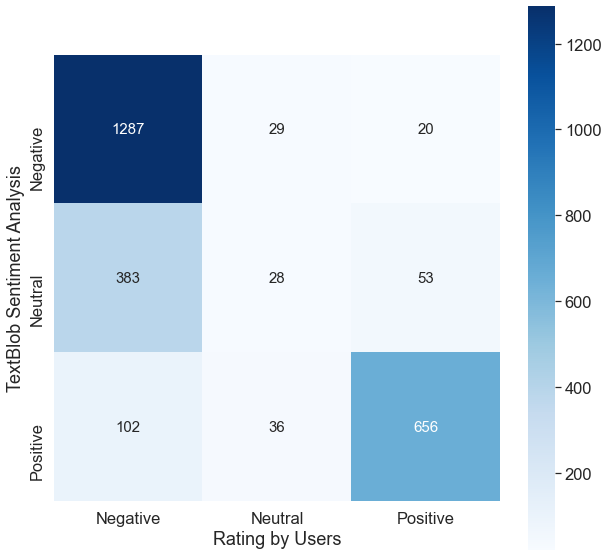

In [569]:
array = confusion_matrix(df.textblob_label , df.rating_label, labels=['Negative', 'Neutral', 'Positive'])
df_cm = pd.DataFrame(array, index = ['Negative', 'Neutral', 'Positive'],
                  columns = ['Negative', 'Neutral', 'Positive'])
sns.set(font_scale=1.5)

df_cm = pd.DataFrame(array, index = ['Negative', 'Neutral', 'Positive'],
                  columns = ['Negative', 'Neutral', 'Positive'])
plt.tight_layout()
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True, fmt="d", square=True, cmap= 'Blues', annot_kws={"fontsize":15})
plt.ylabel('TextBlob Sentiment Analysis', fontsize = 18)
plt.xlabel('Rating by Users', fontsize = 18)
plt.show()

<Figure size 432x288 with 0 Axes>

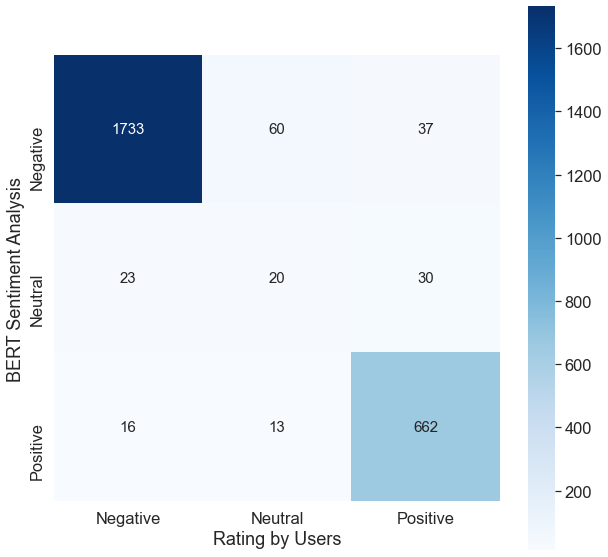

In [570]:
array = confusion_matrix(df.transformer_label , df.rating_label, labels=['Negative', 'Neutral', 'Positive'])
df_cm = pd.DataFrame(array, index = ['Negative', 'Neutral', 'Positive'],
                  columns = ['Negative', 'Neutral', 'Positive'])
sns.set(font_scale=1.5)

df_cm = pd.DataFrame(array, index = ['Negative', 'Neutral', 'Positive'],
                  columns = ['Negative', 'Neutral', 'Positive'])
plt.tight_layout()
plt.figure(figsize = (10,10))
sns.heatmap(df_cm, annot=True, fmt="d", square=True, cmap= 'Blues', annot_kws={"fontsize":15})
plt.ylabel('BERT Sentiment Analysis', fontsize = 18)
plt.xlabel('Rating by Users', fontsize = 18)
plt.show()

In [863]:
f1_score(df.rating_label, df.textblob_label, average='weighted')

0.8114483877048112

In [574]:
def text_preprocessing(text: list):
    nlp = spacy.load("en_core_web_sm")
    review_noun =[]
    
    text = [re.sub('\\S*@\\S*\\s?', '', sent) for sent in text]
    text = [re.sub('\\s+', ' ', sent) for sent in text]
    text = [re.sub("\\'", "", sent) for sent in text] 
    
    # only keep the nouns
    for review in text:
        noun = nlp(review)
        review_noun.append(' '.join([i.text for i in noun.noun_chunks]))
    
    # sentence to words
    review_words = []
    for sent in review_noun:
        review_words.append(gensim.utils.simple_preprocess(str(sent), deacc=True))
   
    #remove numbers and lemmatization    
    docs = [[token for token in doc if not token.isnumeric()] for doc in review_words]
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
    return docs 

In [575]:
def text_preprocessing2(text: list):
    nlp = spacy.load("en_core_web_sm")
    review_noun =[]
    
    text = [re.sub('\\S*@\\S*\\s?', '', sent) for sent in text]
    text = [re.sub('\\s+', ' ', sent) for sent in text]
    text = [re.sub("\\'", "", sent) for sent in text] 
    
    for review in text:
        sent = nlp(review)
        review_noun.append([token.lemma_ for token in sent if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']])
#     print(review_noun[:5])
#   sentence to words
    review_words = []
    for sent in review_noun:
        review_words.append(gensim.utils.simple_preprocess(str(sent), deacc=True))
#     print(review_words[:5])
    #remove numbers and lemmatization    
    docs = [[token for token in doc if not token.isnumeric()] for doc in review_words]
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
    return docs

In [54]:
cs = pd.read_csv('cs_after_sentiments.csv')

In [302]:
teva = pd.read_csv('teva_only.csv', index_col=0)
teva.comments = teva.comments.astype('str')
teva = teva[['comments']]

In [307]:
reviews = teva.comments.values.tolist()
reviews.extend(cs.reviews.values.tolist())
reviews = [re.sub('\\S*@\\S*\\s?', '', sent) for sent in reviews]
reviews = [re.sub('\\s+', ' ', sent) for sent in reviews]
reviews = [re.sub("\\'", "", sent) for sent in reviews]
def reviews_to_words(reviews):
    for sent in reviews:
        yield(gensim.utils.simple_preprocess(str(sent), deacc=True))
list(reviews_to_words(['i like it', "I don't like it"]))
reviews_words = list(reviews_to_words(reviews))

In [308]:
bigrams = Phrases(reviews_words, min_count=1, threshold=10)
trigrams = Phrases(bigrams[reviews_words], min_count=1, threshold=10)
# bigrams.add_vocab(docs)
bigrams_mode = gensim.models.phrases.Phraser(bigrams)

In [573]:
trigrams['great_customer', 'service']

['great_customer_service']

In [589]:
nondup = df.drop_duplicates(keep='first')
nondup

,date,userName,rating,reviews,textblob_score,textblob_label,rating_label,transformer_rating,transformer_label,transformer_label_sentence
0,2021-02-04 19:28:00,julian8000,2,I have never left a review of an app before bu...,0.0,Neutral,Negative,1,Negative,[{'I have never left a review of an app before...
1,2021-02-01 06:00:00,ks2dogs,1,As a client for almost 10 years ensuring two p...,0.0,Neutral,Negative,1,Negative,[{'As a client for almost 10 years ensuring tw...
2,2021-01-22 22:45:00,Gumpy3,1,Seriously?!?! You have been sending me emails ...,0.2,Positive,Negative,1,Negative,[{'Seriously?!?! You have been sending me emai...
3,2021-02-13 02:39:00,hurolope,1,I’m not sure who designed and approved this ap...,-0.1,Negative,Negative,2,Negative,[{'I’m not sure who designed and approved this...
4,2020-12-18 20:18:00,Pigglette69,4,"New App is a joke. Loose the Leo interface, i...",0.0,Neutral,Positive,1,Negative,"[{'New App is a joke.': 'Negative', 'Loose the..."
...,...,...,...,...,...,...,...,...,...,...
2589,2021-02-26 15:09:00,Asaf,3,It’s the second time that I had trouble until ...,0.0,Neutral,Neutral,1,Negative,[{'It’s the second time that I had trouble unt...
2590,2021-02-26 15:08:00,Debra,5,Always helpful and caring!,0.0,Neutral,Positive,5,Positive,[{'Always helpful and caring!': 'Positive'}]
2591,2021-02-26 15:06:00,Tod,1,My experience with your new website has been d...,-0.2,Negative,Negative,1,Negative,[{'My experience with your new website has bee...
2592,2021-02-26 15:06:00,Cristina,1,Because you guys keep messing with the app and...,0.0,Neutral,Negative,1,Negative,[{'Because you guys keep messing with the app'...


In [601]:
reviews = nondup.reviews.values.tolist()
docs = text_preprocessing(reviews)

In [602]:
reviews[0]

'I have never left a review of an app before but this new app is extremely frustrating and wastes an extraordinary amount of time for simple tasks like updating billing information or home address. The previous app was simple and efficient. I did manage to submit my claims via the Leo bot - so now I’m crossing my fingers that these new changes in the app and website aren’t indicators of an overall decline in this company 🤞🏼'

In [606]:
stopwords_list = stopwords.words('english')
# stopwords_list.extend(['thats', 'fres', 'years', 'best', 'day', 'days','coin', 'coin_base', 'bit','coinbase',
#                            'time','would', 'week', 'anything', 'everything', 'nothing', 'lot'])
# "app", "petplan","company","will","day","much","I","It","even","t","review","time",
#                  "yesterday","This","pet","work","new","old","one","now","website","back","make","s","year"
#                  ,"way","try","anything","years","never","use","better","doesn","dont","week","star",'Claim','Customer'
#                   ,'Service','dog','Pet','pet','claims','w
final_docs = [[word for word in doc if word not in stopwords_list] for doc in docs]
final_docs = [[word for word in doc if word not in 
               ['insurance', "petplan","company",'plan', 'time', 'dog','one', 'year', 'month', 'way', 'pet', 'pet_plan']] for doc in final_docs]
final_docs = list(bigrams[final_docs])
final_docs = list(trigrams[final_docs])
# final_docs = [[word for word in doc if word not in 
#                ['insurance', "petplan","company",'plan', 'time', 'dog', 'pet_plan']] for doc in final_docs]

In [608]:
bag_words = []
for doc in final_docs:
    bag_words.extend(doc)
freq_list = FreqDist(bag_words)
print('\n-----------------')
freq_list.most_common(20)


-----------------


[('claim', 302),
 ('app', 232),
 ('website', 66),
 ('question', 66),
 ('customer_service', 63),
 ('issue', 55),
 ('phone', 52),
 ('policy', 50),
 ('information', 47),
 ('service', 47),
 ('new', 46),
 ('email', 45),
 ('payment', 43),
 ('customer', 38),
 ('account', 36),
 ('anything', 35),
 ('vet', 35),
 ('someone', 34),
 ('problem', 34),
 ('new_app', 31)]

In [618]:
to_dict = gensim.corpora.Dictionary(final_docs)
corpus = [to_dict.doc2bow(doc) for doc in final_docs]
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=to_dict,
                                           num_topics=4,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           alpha='auto',
                                           eta = 'auto',
                                           per_word_topics=True)

In [619]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score, higher the better
coherence_model_lda = CoherenceModel(model=lda_model, texts=final_docs, dictionary=to_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.638073471661084

Coherence Score:  0.3049067005494785


In [620]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, to_dict)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.020370 -0.046786       1        1  31.508779
1     -0.107846  0.025709       2        1  29.461901
2      0.061473 -0.078360       3        1  22.689127
0      0.066743  0.099436       4        1  16.340194, topic_info=           Term        Freq       Total Category  logprob  loglift
1           app  190.000000  190.000000  Default  30.0000  30.0000
189     service   39.000000   39.000000  Default  29.0000  29.0000
5         claim  242.000000  242.000000  Default  28.0000  28.0000
20      website   51.000000   51.000000  Default  27.0000  27.0000
14      new_app   24.000000   24.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
1           app    5.787341  190.126362   Topic4  -4.9971  -1.6805
104      people    3.812125   23.736034   Topic4  -5.4145  -0.0173
102     payment    3.971875   34.464048   Topic4  -5.3735  -0.3491
174  experience    3.663368   19.781567   Topic4  -5.4543   0.1252
101      number    3.533378   14.916496   Topic4  -5.4905   0.3713

[296 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
153       3  0.858738  ability
69        1  0.169102  account
69        2  0.405846  account
69        3  0.372025  account
69        4  0.033820  account
...     ...       ...      ...
139       3  0.153483     week
730       2  0.737101     well
550       2  0.824784    world
636       4  0.917945      wth
275       2  0.824745     zero

[447 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

In [623]:
pyLDAvis.save_html(vis, 'hotjar_four_topics.html')

In [790]:
import ast
x = ast.literal_eval(df.transformer_label_sentence[0])
x

[{'I have never left a review of an app before but this new app is extremely frustrating and wastes an extraordinary amount of time for simple tasks like updating billing information or home address.': 'Negative',
  'The previous app was simple and efficient.': 'Positive',
  'I did manage to submit my claims via the Leo bot - so now I’m crossing my fingers that these new changes in the app and website aren’t indicators of an overall decline in this company': 'Negative',
  '🤞🏼': 'Positive'}]

In [791]:
review_label_by_sents = {}
for i in df.transformer_label_sentence:
    i = ast.literal_eval(i)
    review_label_by_sents.update(i[0])
review_label_by_sents

{'I have never left a review of an app before but this new app is extremely frustrating and wastes an extraordinary amount of time for simple tasks like updating billing information or home address.': 'Negative',
 'The previous app was simple and efficient.': 'Positive',
 'I did manage to submit my claims via the Leo bot - so now I’m crossing my fingers that these new changes in the app and website aren’t indicators of an overall decline in this company': 'Negative',
 '🤞🏼': 'Positive',
 'As a client for almost 10 years ensuring two pets, I have routinely referred even random strangers to Petplan due to the great Customer Service and ease of claims administration.': 'Positive',
 'The new app and website are AWFUL.': 'Negative',
 'I just filed first claim online, no confirmation, no claim number and doesn’t show in my history and the easy press to call customer service is no longer an option.': 'Negative',
 'In case it might have been isolated incident, I perused the other reviews to fin

In [792]:
words_re = re.compile("|".join(['(?i)claim', '(?i)file','(?i)filing', '(?i)submit']))

claim_related = {}
for k,v in review_label_by_sents.items():
    if words_re.search(k):
        claim_related[k] = v 

In [793]:
words_re = re.compile("|".join(['(?i)customer service', '(?i)customer support', '(?i)representative']))

customerservice_related = {}
for k,v in review_label_by_sents.items():
    if words_re.search(k):
        customerservice_related[k] = v

In [794]:
words_re = re.compile("|".join(['(?i)\\bapp\\b', '(?i)application']))

app_related = {}
for k,v in review_label_by_sents.items():
    if words_re.search(k):
        app_related[k] = v

In [795]:
words_re = re.compile("|".join(['(?i)\\bweb\\b', '(?i)website']))

web_related = {}
for k,v in review_label_by_sents.items():
    if words_re.search(k):
        web_related[k] = v

In [811]:
claims = pd.Series(claim_related.values()).value_counts().sort_index()*3
customer_service = pd.Series(customerservice_related.values()).value_counts().sort_index()*3
app = pd.Series(app_related.values()).value_counts().sort_index()*3
web = pd.Series(web_related.values()).value_counts().sort_index()*3

In [812]:
claims

Negative    612
Neutral     150
Positive    267
dtype: int64

In [813]:
customer_service

Negative    150
Neutral      60
Positive    138
dtype: int64

In [814]:
app

Negative    570
Neutral     114
Positive    156
dtype: int64

In [815]:
web

Negative    195
Neutral      36
Positive     63
dtype: int64

In [816]:
topics = pd.DataFrame([claims, customer_service, app, web]).transpose()
topics.columns =['claims', 'customer_service', 'app', 'web']
topics.to_csv('Petplan_topics.csv')

In [607]:
x = []
for idx in range(len(final_docs)):
    for token in final_docs[idx]:
        if '_' in token:
            x.append(token)
freq_list = FreqDist(x)
print('\n-----------------')
freq_list.most_common(50)


-----------------


[('customer_service', 63),
 ('new_app', 31),
 ('old_app', 17),
 ('credit_card', 16),
 ('new_website', 15),
 ('phone_call', 12),
 ('real_person', 10),
 ('claim_submission', 7),
 ('customer_service_rep', 7),
 ('mobile_app', 7),
 ('monthly_payment', 7),
 ('direct_deposit', 7),
 ('claim_process', 6),
 ('phone_number', 6),
 ('web_site', 6),
 ('gift_card', 6),
 ('great_customer_service', 5),
 ('claim_status', 5),
 ('payment_information', 5),
 ('old_website', 5),
 ('new_system', 5),
 ('old_system', 5),
 ('previous_version', 4),
 ('monthly_premium', 4),
 ('new_site', 4),
 ('customer_service_representative', 4),
 ('answering_service', 4),
 ('excellent_customer_service', 4),
 ('home_address', 3),
 ('three_different', 3),
 ('live_person', 3),
 ('family_member', 3),
 ('renewal_date', 3),
 ('several_people', 3),
 ('existing_claim', 3),
 ('checking_account', 3),
 ('debit_card', 3),
 ('online_portal', 3),
 ('customer_service_person', 3),
 ('pre_existing', 3),
 ('great_job', 3),
 ('generic_answer', 2)

In [817]:
bag_words = []
for doc in final_docs:
    bag_words.extend(doc)
freq_list = FreqDist(bag_words)
print('\n-----------------')
freq_list.most_common(20)


-----------------


[('app', 223),
 ('claim', 219),
 ('call', 139),
 ('answer', 71),
 ('website', 66),
 ('submit_claim', 65),
 ('question', 63),
 ('email', 59),
 ('contact', 58),
 ('good', 57),
 ('issue', 57),
 ('pay', 57),
 ('service', 57),
 ('customer_service', 56),
 ('phone', 53),
 ('new', 52),
 ('policy', 50),
 ('tell', 49),
 ('help', 49),
 ('information', 47)]

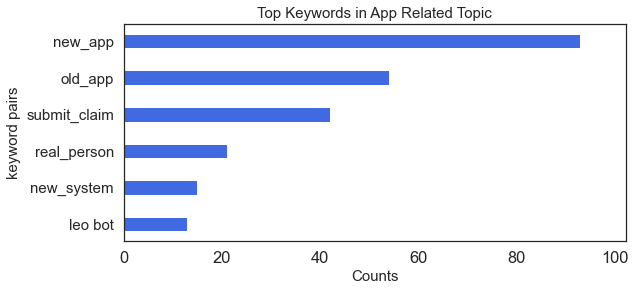

In [833]:
plt.style.use('seaborn-ticks')
plt.figure(figsize=(9,4), facecolor='w')
x = [93, 54, 42, 21, 15, 13]
y = ['new_app', 'old_app', 'submit_claim', 'real_person', 'new_system', 'leo bot']
plt.barh(y[::-1], x[::-1], color ='royalblue', height= 0.4) 
plt.margins(y=0.05, x = 0.1)  
plt.yticks(fontsize = 15)
plt.xlabel("Counts", fontsize = 15) 
plt.ylabel("keyword pairs", fontsize = 15, labelpad=5) 
plt.title("Top Keywords in App Related Topic", fontsize = 15) 
plt.show() 

In [837]:
pd.DataFrame(df.rating.value_counts().sort_index()).reset_index().to_csv('petplan_ratings.csv')

In [874]:
df['day'] = df.date.dt.to_period('d')

In [875]:
df.sort_values('day')

,date,userName,rating,reviews,textblob_score,textblob_label,rating_label,transformer_rating,transformer_label,transformer_label_sentence,day
88,2020-01-25 22:59:00,AliRHP,2,They just updated everything so that all the a...,0.0,Neutral,Negative,3,Neutral,[{'They just updated everything so that all th...,2020-01-25
90,2020-02-24 17:32:00,Zxcvbnmpoi,2,New app won’t even recognize my login info. To...,0.1,Positive,Negative,1,Negative,[{'New app won’t even recognize my login info....,2020-02-24
83,2020-02-27 22:41:00,Dalmom71,3,My 3 star review is solely about the app and n...,0.5,Positive,Neutral,3,Neutral,[{'My 3 star review is solely about the app an...,2020-02-27
859,2020-03-03 23:15:00,you can't fix it,1,It’s fine when it works but it’s down 99.99% o...,-0.1,Negative,Negative,2,Negative,"[{'It’s fine when it works': 'Neutral', 'but i...",2020-03-03
1189,2020-03-03 23:15:00,you can't fix it,1,It’s fine when it works but it’s down 99.99% o...,-0.1,Negative,Negative,2,Negative,"[{'It’s fine when it works': 'Neutral', 'but i...",2020-03-03
...,...,...,...,...,...,...,...,...,...,...,...
1892,2021-03-04 12:27:00,Shawn,3,i was charged when i wasnt supposed to\r,0.0,Neutral,Neutral,1,Negative,[{'i was charged when i wasnt supposed to': 'N...,2021-03-04
1891,2021-03-04 12:37:00,Staci,1,"I called on Monday, and my issue has still not...",0.0,Neutral,Negative,1,Negative,"[{'I called on Monday, and my issue has still ...",2021-03-04
1890,2021-03-04 12:56:00,Patricia Brown,3,I cancelled Petplan so this does not apply to ...,0.0,Neutral,Neutral,1,Negative,[{'I cancelled Petplan so this does not apply ...,2021-03-04
1889,2021-03-04 13:43:00,Angela Rowe,3,"i prefer to speak to a person,Especially when ...",0.0,Neutral,Neutral,2,Negative,"[{'i prefer to speak to a person,Especially wh...",2021-03-04


In [844]:
value = pd.DataFrame(df.groupby('day')['rating'].mean())
value.reset_index(inplace = True)
value.to_csv('rating_over_time.csv')

In [828]:
words_re = re.compile("|".join(['(?i)real person']))

test = {}
for k,v in review_label_by_sents.items():
    if words_re.search(k):
        test[k] = v

In [829]:
test

{'I appreciate it, when I can speak with a real person.': 'Neutral',
 'But, this time I hard a very hard time getting in touch with a real person to discuss my concerns.': 'Neutral',
 'Second, a claim of mine went almost two months with no action on it, and it was nearly impossible to speak to a real person about it.': 'Negative',
 'Just hate recordings cause it takes too to get to talk to a real person': 'Negative',
 'I like talking to a REAL person and not pushing 1,2,3 numbers.': 'Positive',
 "When I've always called in the past, I have spoken to a REAL person,  and I want that to continue!": 'Positive',
 'I had to speak with a real person I kept looking at my account & it continually stated I owed nothing.': 'Negative',
 'I am not a very confident computer person would love ke to talk to a real person when am calling you guys.': 'Negative',
 'I would rather talk to a real person.': 'Negative',
 'I want to speak to a real person immediately': 'Positive'}

In [ ]:
app_related

In [872]:
with pd.option_context('display.max_colwidth', None): 
    display(
df[df.reviews.str.contains('customer service',case = False, regex=True)]['transformer_label_sentence'])

1       [{'As a client for almost 10 years ensuring two pets, I have routinely referred even random strangers to Petplan due to the great Customer Service and ease of claims administration.': 'Positive', 'The new app and website are AWFUL.': 'Negative', 'I just filed first claim online, no confirmation, no claim number and doesn’t show in my history and the easy press to call customer service is no longer an option.': 'Negative', 'In case it might have been isolated incident, I perused the other reviews to find sadly it is not.': 'Negative', 'As someone who sells software, I am dumbfounded that this could get through QA or that ANYONE viewed this as a better UI.': 'Negative', 'We are adults and don’t need a cartoon to walk us through each step to file a claim.': 'Negative', 'And to top it off, as Leo takes you through each step, edit/back options are nonexistent.': 'Negative', 'In my case, as I was nearing the end the question ‘do you have additional invoices popped up’.': 'Neutral', '

In [153]:
bag_words = ' '.join(bag_words)

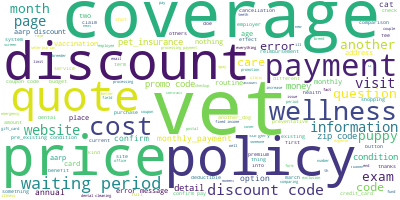

In [156]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5, prefer_horizontal=1.0, contour_color='steelblue')
wordcloud.generate(bag_words)
wordcloud.to_image()

In [624]:
reviews = nondup.reviews.values.tolist()
docs = text_preprocessing2(reviews)

In [768]:
stopwords_list = stopwords.words('english')
# stopwords_list.extend(['thats', 'fres', 'years', 'best', 'day', 'days','coin', 'coin_base', 'bit','coinbase',
#                            'time','would', 'week', 'anything', 'everything', 'nothing', 'lot'])
# "app", "petplan","company","will","day","much","I","It","even","t","review","time",
#                  "yesterday","This","pet","work","new","old","one","now","website","back","make","s","year"
#                  ,"way","try","anything","years","never","use","better","doesn","dont","week","star",'Claim','Customer'
#                   ,'Service','dog','Pet','pet','claims','w
final_docs = [[word for word in doc if word not in stopwords_list] for doc in docs]
final_docs = [[word for word in doc if word not in 
               ['insurance', "petplan","company",'plan', 'time','well', 'never','back',
                'still','always', 'dog','one','need', 'try','go','much', 'send', 'say','easy','work', 'use', 'helpful', 'get', 'would','make', 'take', 'year', 'month', 'way', 'pet', 'pet_plan']] for doc in final_docs]
final_docs = list(bigrams[final_docs])
final_docs = list(trigrams[final_docs])
# final_docs = [[word for word in doc if word not in ['petplan', "petplan","company","will","day","much","I","It","even","t","review","time",
#                  "yesterday","This","pet","work","one","now","back","make","s","year"
#                  ,"way","try","anything","years","never","use","doesn","dont","week","star",'dog','see','say', 'Pet','pet','w','need','please','plan','go','said','insurance','always','yes'
#                   ,'want','yet','Will', 'plan', 'pet_plan', 'would_like']] for doc in final_docs]

In [769]:
x = []
for idx in range(len(final_docs)):
    for token in final_docs[idx]:
        if '_' in token:
            x.append(token)
freq_list = FreqDist(x)
print('\n-----------------')
freq_list.most_common(50)


-----------------


[('submit_claim', 65),
 ('customer_service', 56),
 ('file_claim', 34),
 ('new_app', 30),
 ('old_app', 17),
 ('credit_card', 16),
 ('user_friendly', 16),
 ('new_website', 15),
 ('phone_call', 14),
 ('access_account', 11),
 ('claim_process', 11),
 ('call_customer_service', 9),
 ('claim_submission', 8),
 ('direct_deposit', 8),
 ('real_person', 8),
 ('monthly_payment', 7),
 ('mobile_app', 6),
 ('phone_number', 6),
 ('ask_question', 6),
 ('web_site', 6),
 ('gift_card', 6),
 ('update_payment', 5),
 ('old_website', 5),
 ('new_system', 5),
 ('old_system', 5),
 ('claim_status', 4),
 ('customer_service_rep', 4),
 ('straight_forward', 4),
 ('previous_version', 4),
 ('live_person', 4),
 ('monthly_premium', 4),
 ('customer_service_representative', 4),
 ('new_site', 4),
 ('right_away', 4),
 ('debit_card', 4),
 ('week_ago', 4),
 ('pre_existing', 4),
 ('home_address', 3),
 ('could_afford', 3),
 ('family_member', 3),
 ('renewal_date', 3),
 ('several_people', 3),
 ('highly_recommend', 3),
 ('quick_respo

In [822]:
bag_words = []
for doc in final_docs:
    bag_words.extend(doc)
freq_list = FreqDist(bag_words)
print('\n-----------------')
freq_list.most_common(50)


-----------------


[('app', 223),
 ('claim', 219),
 ('call', 139),
 ('answer', 71),
 ('website', 66),
 ('submit_claim', 65),
 ('question', 63),
 ('email', 59),
 ('contact', 58),
 ('good', 57),
 ('issue', 57),
 ('pay', 57),
 ('service', 57),
 ('customer_service', 56),
 ('phone', 53),
 ('new', 52),
 ('policy', 50),
 ('tell', 49),
 ('help', 49),
 ('information', 47),
 ('change', 47),
 ('able', 45),
 ('speak', 44),
 ('could', 43),
 ('payment', 43),
 ('even', 41),
 ('great', 41),
 ('receive', 41),
 ('also', 40),
 ('want', 39),
 ('long', 38),
 ('customer', 38),
 ('find', 37),
 ('thank', 37),
 ('give', 37),
 ('upload', 37),
 ('day', 36),
 ('submit', 36),
 ('problem', 35),
 ('like', 35),
 ('file_claim', 34),
 ('process', 34),
 ('cancel', 33),
 ('talk', 33),
 ('see', 33),
 ('info', 33),
 ('check', 33),
 ('update', 32),
 ('last', 32),
 ('money', 32)]

In [765]:
to_dict = gensim.corpora.Dictionary(final_docs)
corpus = [to_dict.doc2bow(doc) for doc in final_docs]
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=to_dict,
#                                            random_state=200,
                                           num_topics=4,
                                           update_every=1,
                                           chunksize=500,
                                           passes=10,
                                           alpha='auto',
                                           eta = 'auto',
                                           per_word_topics=True)

In [766]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score, higher the better
coherence_model_lda = CoherenceModel(model=lda_model, texts=final_docs, dictionary=to_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.043505700724543

Coherence Score:  0.326383596090557


In [767]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, to_dict)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.028232  0.065697       1        1  28.497901
1     -0.056524 -0.120091       2        1  26.468831
0     -0.067707  0.060073       3        1  23.254880
2      0.152463 -0.005679       4        1  21.778388, topic_info=               Term        Freq       Total Category  logprob  loglift
36            claim  191.000000  191.000000  Default  30.0000  30.0000
1               app  168.000000  168.000000  Default  29.0000  29.0000
126            good   53.000000   53.000000  Default  28.0000  28.0000
86         question   60.000000   60.000000  Default  27.0000  27.0000
173            info   29.000000   29.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
518        friendly    8.801748   20.355412   Topic4  -5.3850   0.6859
1               app   11.655861  168.968838   Topic4  -5.1041  -1.1497
385         receive    9.155046   36.365356   Topic4  -5.3457   0.1449
22     submit_claim    8.855975   56.450322   Topic4  -5.3789  -0.3280
739  representative    8.502131   25.368593   Topic4  -5.4196   0.4311

[297 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
107       1  0.247628      able
107       2  0.024763      able
107       3  0.272391      able
107       4  0.445731      able
294       2  0.102437    accept
...     ...       ...       ...
246       3  0.790526      week
1107      1  0.754152  week_ago
927       4  0.808274   willing
1492      2  0.730697    wonder
503       2  0.770736     worth

[471 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

In [736]:
pyLDAvis.save_html(vis, 'hotjar_four_topics2.html')

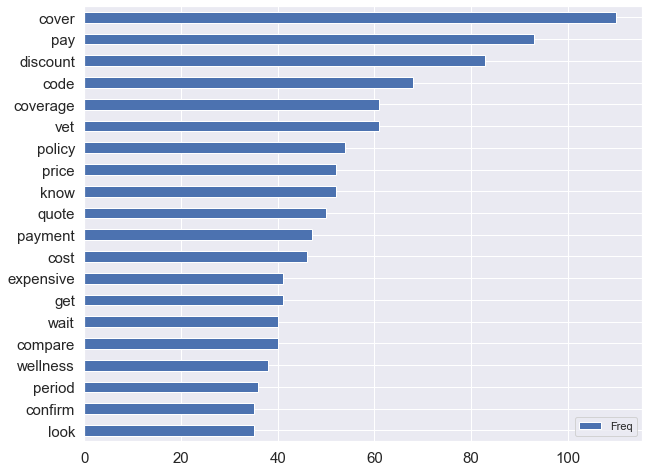

In [125]:
data = data.sort_values(by='Freq', ascending=False)
data.head(20).sort_values('Freq').plot(kind='barh',figsize=(10,8),fontsize =15)
plt.show()

In [275]:
proair = pd.read_csv('proair_respiclick.csv', index_col=0)
proair=proair[['date', 'comments', 'years_use', 'uses', 'rating']].reset_index(drop=True)
proair.comments = proair.comments.astype('str')
proair

,date,comments,years_use,uses,rating
0,2021-03-11,I was switch from my pro air to the albuteral ...,Taken for 1 to 6 months,"For Asthma, acute:",1.0
1,2020-12-30,"I love it, I prefer it to the others I have tr...",Taken for 1 to 2 years,"For Asthma, acute:",9.0
2,2020-11-22,My insurance changed recently due to a new job...,Taken for less than 1 month,"For Asthma, Maintenance:",1.0
3,2020-11-20,I have never had a problem with these inhalers...,Taken for 2 to 5 years,"For Asthma, acute:",8.0
4,2020-09-06,This new inhaler ProAir RespiClick doesn't do...,NaN,"For Asthma, acute:",NaN
...,...,...,...,...,...
98,2016-03-01,I was given this to help with bronchiospasms d...,NaN,For Bronchospasm Prophylaxis:,1.0
99,2016-02-12,It did not do anything for me! Awful product!,NaN,"For Asthma, acute:",1.0
100,2016-02-09,Horrible ! My husband has asthma and his doct...,Taken for 1 to 6 months,"For Asthma, acute:",2.0
101,2016-01-18,I also switched to the respiclick. It was zero...,NaN,"For Asthma, acute:",1.0


In [276]:
classifier = trans_bert_score()
star_number = {'1 star': 1, '2 stars': 2, '3 stars': 3, '4 stars': 4, '5 stars': 5}
proair['transformer_rating'] = proair.comments.apply(lambda x: star_number[classifier.label_bert_by_reviews(x)])

In [279]:
num_senti = {1:'Negative', 2: 'Negative', 3: 'Neutral', 4: 'Positive', 5: 'Positive'}
proair['transformer_label'] = proair.transformer_rating.apply(lambda x: num_senti[x])
proair

,date,comments,years_use,uses,rating,transformer_rating,transformer_label
0,2021-03-11,I was switch from my pro air to the albuteral ...,Taken for 1 to 6 months,"For Asthma, acute:",1.0,1,Negative
1,2020-12-30,"I love it, I prefer it to the others I have tr...",Taken for 1 to 2 years,"For Asthma, acute:",9.0,5,Positive
2,2020-11-22,My insurance changed recently due to a new job...,Taken for less than 1 month,"For Asthma, Maintenance:",1.0,1,Negative
3,2020-11-20,I have never had a problem with these inhalers...,Taken for 2 to 5 years,"For Asthma, acute:",8.0,4,Positive
4,2020-09-06,This new inhaler ProAir RespiClick doesn't do...,NaN,"For Asthma, acute:",NaN,1,Negative
...,...,...,...,...,...,...,...
98,2016-03-01,I was given this to help with bronchiospasms d...,NaN,For Bronchospasm Prophylaxis:,1.0,1,Negative
99,2016-02-12,It did not do anything for me! Awful product!,NaN,"For Asthma, acute:",1.0,1,Negative
100,2016-02-09,Horrible ! My husband has asthma and his doct...,Taken for 1 to 6 months,"For Asthma, acute:",2.0,1,Negative
101,2016-01-18,I also switched to the respiclick. It was zero...,NaN,"For Asthma, acute:",1.0,1,Negative


In [283]:
classifier = trans_bert_score()
proair['transformer_label_sentence'] = proair.comments.apply(lambda x: [classifier.score_by_sentence(x)])

In [ ]:
label = {1:'Negative', 2: 'Negative', 3: 'Negative', 4: 'Negative', 5: 'Neutral', 6: 'Neutral', 7:'Positive', 8:'Positive', 9:'Positive', 10:'Positive', None:'NaN'}
proair['rating_label'] = proair.rating.apply(lambda x: label[x] if pd.notna(x) else None)
proair

In [292]:
proair_notna = proair[proair.rating_label.notna()]

<Figure size 432x288 with 0 Axes>

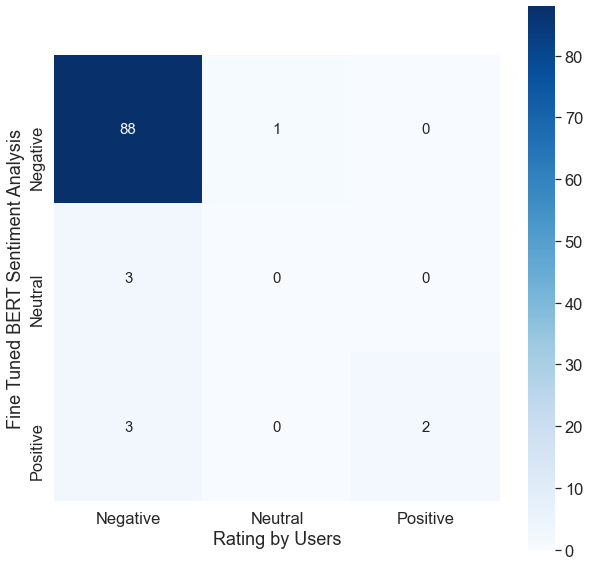

In [293]:
array = confusion_matrix(proair_notna.transformer_label , proa ir_notna.rating_label, labels=['Negative', 'Neutral', 'Positive'])
proair_notna_cm = pd.DataFrame(array, index = ['Negative', 'Neutral', 'Positive'],
                  columns = ['Negative', 'Neutral', 'Positive'])
sns.set(font_scale=1.5)

proair_notna_cm = pd.DataFrame(array, index = ['Negative', 'Neutral', 'Positive'],
                  columns = ['Negative', 'Neutral', 'Positive'])
plt.tight_layout()
plt.figure(figsize = (10,10))
sns.heatmap(proair_notna_cm, annot=True, fmt="d", square=True, cmap= 'Blues', annot_kws={"fontsize":15})
plt.ylabel('Fine Tuned BERT Sentiment Analysis', fontsize = 18)
plt.xlabel('Rating by Users', fontsize = 18)
plt.show()

In [ ]:
reviews = proair.comments.values.tolist()
docs = text_preprocessing2(reviews)
docs[:5]

In [407]:
stopwords_list = stopwords.words('english')
# stopwords_list.extend(['thats', 'fres', 'years', 'best', 'day', 'days','coin', 'coin_base', 'bit','coinbase',
#                            'time','would', 'week', 'anything', 'everything', 'nothing', 'lot'])
# "app", "petplan","company","will","day","much","I","It","even","t","review","time",
#                  "yesterday","This","pet","work","new","old","one","now","website","back","make","s","year"
#                  ,"way","try","anything","years","never","use","better","doesn","dont","week","star",'Claim','Customer'
#                   ,'Service','dog','Pet','pet','claims','w
final_docs = [[word for word in doc if word not in stopwords_list] for doc in docs]
final_docs = [[word for word in doc if word not in 
               ['wa', 'respiclick', 'pro', 'air', 'proair', 'work', 'use', 'inhaler', 'get','even', 'feel', 'come']] for doc in final_docs]
final_docs = list(bigrams[final_docs])
final_docs = list(trigrams[final_docs])
# final_docs = [[word for word in doc if word not in 
#                ['wa', 'inhaler', 'respiclick', 'pro_air']] for doc in final_docs]

In [408]:
x = []
for idx in range(len(final_docs)):
    for token in final_docs[idx]:
        if '_' in token:
            x.append(token)
freq_list = FreqDist(x)
print('\n-----------------')
freq_list.most_common(50)


-----------------


[('asthma_attack', 12),
 ('breathe_deeply', 4),
 ('strong_enough', 3),
 ('need_rescue', 3),
 ('switch_back', 3),
 ('go_back', 3),
 ('insurance_company', 3),
 ('mouth_piece', 2),
 ('black_surface', 2),
 ('dispense_medicine', 2),
 ('thank_goodness', 2),
 ('breathing_treatment', 2),
 ('suck_hard', 2),
 ('lung_function', 2),
 ('rating_would', 2),
 ('hard_enough', 2),
 ('suck_hard_enough', 2),
 ('symptom_relief', 2),
 ('instant_relief', 2),
 ('pay_copay', 2),
 ('heart_race', 2),
 ('acute_asthma', 2),
 ('make_sure', 2),
 ('garbage_product', 2),
 ('design_flaw', 2),
 ('free_coupon', 2),
 ('new_job', 1),
 ('immediate_relief', 1),
 ('new_insurance', 1),
 ('new_prescription', 1),
 ('old_style', 1),
 ('dont_want', 1),
 ('chest_pain', 1),
 ('new_drug', 1),
 ('year_ago', 1),
 ('next_day', 1),
 ('primary_doctor', 1),
 ('wish_could_rate', 1),
 ('bad_thing', 1),
 ('delivery_system', 1),
 ('old_method', 1),
 ('far_superior', 1),
 ('deeply_enough', 1),
 ('common_sense', 1),
 ('could_afford', 1),
 ('old_

In [427]:
bag_words = []
for doc in final_docs:
    bag_words.extend(doc)
freq_list = FreqDist(bag_words)
print('\n-----------------')
freq_list.most_common(40)


-----------------


[('relief', 33),
 ('powder', 31),
 ('medicine', 30),
 ('product', 24),
 ('give', 23),
 ('lung', 22),
 ('breathe', 21),
 ('breath', 21),
 ('try', 20),
 ('make', 20),
 ('go', 18),
 ('find', 18),
 ('asthma', 18),
 ('medication', 17),
 ('need', 16),
 ('take', 16),
 ('old', 16),
 ('would', 16),
 ('could', 16),
 ('think', 15),
 ('inhale', 15),
 ('rescue', 15),
 ('absolutely', 14),
 ('dose', 14),
 ('attack', 13),
 ('well', 12),
 ('open', 12),
 ('asthma_attack', 12),
 ('tell', 11),
 ('bad', 11),
 ('insurance', 11),
 ('new', 11),
 ('doctor', 11),
 ('one', 11),
 ('also', 11),
 ('help', 11),
 ('good', 10),
 ('back', 10),
 ('know', 10),
 ('still', 10)]

In [410]:
to_dict = gensim.corpora.Dictionary(final_docs)
corpus = [to_dict.doc2bow(doc) for doc in final_docs]
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=to_dict,
                                           num_topics=3,
                                           random_state=200,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=10,
                                           alpha='auto',
                                           eta = 'auto',
                                           per_word_topics=True)

In [411]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score, higher the better
coherence_model_lda = CoherenceModel(model=lda_model, texts=final_docs, dictionary=to_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.427588566560713

Coherence Score:  0.3136567780192796


In [412]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, to_dict)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.087389  0.001268       1        1  35.975485
2      0.042398 -0.064756       2        1  33.260959
0      0.044990  0.063489       3        1  30.763556, topic_info=           Term       Freq      Total Category  logprob  loglift
19      breathe  15.000000  15.000000  Default  30.0000  30.0000
127       could  12.000000  12.000000  Default  29.0000  29.0000
123       would  12.000000  12.000000  Default  28.0000  28.0000
105    medicine  22.000000  22.000000  Default  27.0000  27.0000
104        lung  16.000000  16.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
77          old   4.005955  12.273245   Topic3  -5.0667   0.0592
16   absolutely   3.769173  10.886727   Topic3  -5.1277   0.1182
11        think   3.806120  11.611666   Topic3  -5.1179   0.0634
127       could   3.795246  12.249151   Topic3  -5.1208   0.0071
18       breath   3.775252  15.937618   Topic3  -5.1261  -0.2614

[223 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
311       1  0.279168        able
311       3  0.697920        able
16        1  0.459275  absolutely
16        2  0.183710  absolutely
16        3  0.367420  absolutely
...     ...       ...         ...
123       1  0.407072       would
123       3  0.569901       would
148       1  0.678807       wrong
416       1  0.755339        year
416       2  0.302135        year

[282 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

In [426]:
pyLDAvis.save_html(vis, 'proair.html')

In [786]:
proair.transformer_label_sentence[0]

[{'I was switch from my pro air to the albuteral respiclick.': 'Positive',
  'I will tell you now': 'Positive',
  'I think it is one of the worst  I have ever used.': 'Negative',
  'I wake in the morning': 'Positive',
  'needing relief ASAP and respiclick sends me down a nightmarish road.': 'Negative'}]

In [ ]:
review_label_by_sents = {}
for i in proair.transformer_label_sentence:
    review_label_by_sents.update(i[0])
review_label_by_sents

In [416]:
words_re = re.compile("|".join(['(?i)powder']))

powder_related = {}
for k,v in review_label_by_sents.items():
    if words_re.search(k):
        powder_related[k] = v

In [417]:
powder_related

{'I think a lot of the issues people are having is if they are unable to breath in strong enough to inhale the powder.': 'Neutral',
 'No powder or spray  comes out.': 'Negative',
 'I have to use a powder.': 'Neutral',
 'The powder is in a capsule that spun in the rotahaler as you breathe in.': 'Negative',
 'Breathing in the powder is no different to the puffer.': 'Negative',
 'We put it on a black surface, click the inhaler and banged it on the black counter and absolutely no powder or mist came out.': 'Negative',
 'It dispenses the medicine in a powder instead of finer air size particles': 'Neutral',
 "This obviously doesn't work very well because air can be breathed into your lungs whereas a powder gets stuck somewhere along the way from your mouth to your lungs.": 'Negative',
 "I can literally feel the powder getting stuck in my throat instead of going where it's supposed to.": 'Negative',
 'I did feel/ taste the powder on the back of my tongue': 'Neutral',
 "When one is wheezing an

In [418]:
words_re = re.compile("|".join(['(?i)relief']))

effectiveness_related = {}
for k,v in review_label_by_sents.items():
    if words_re.search(k):
        effect_related[k] = v

In [419]:
effect_related

{'needing relief ASAP and respiclick sends me down a nightmarish road.': 'Negative',
 'I was taking ProAir HFA which worked very well giving me immediate relief.': 'Positive',
 'I now have coverage for ProAir RespiClick from which I have gotten zero relief.': 'Negative',
 'I mean absolutely no relief, it’s completely ineffective.': 'Negative',
 'but there is noooooo relief.': 'Neutral',
 'I found absolutely no relief from the $60 Respliclick.': 'Negative',
 'No relief after using!!!': 'Negative',
 'I was able to get relief with that inhaler': 'Positive',
 "I have also used the ProAir RespiClick device for my reactive airway symptoms to determine why my patients are complaining that they aren't experiencing any symptom relief with it.": 'Positive',
 'In the event of an asthmatic episode, the patient is already struggling to breathe deeply/forcefully, hence their urgent need for relief.': 'Neutral',
 'With the aerosol Albuterol, I feel instant relief in the tightness in my chest.': 'Posi

In [468]:
words_re = re.compile("|".join(['(?i)breath','(?i)suck', '(?i)\\binhale\\b']))

breath_related = {}
for k,v in review_label_by_sents.items():
    if words_re.search(k):
        breath_related[k] = v

In [469]:
breath_related

{'The process to inhale the medication is ludicrous.': 'Positive',
 'Breathe deeply (when you can barely breathe at all) and the hold your breath for 10 seconds!': 'Positive',
 'I think a lot of the issues people are having is if they are unable to breath in strong enough to inhale the powder.': 'Neutral',
 'so I can breathe.': 'Neutral',
 'The powder is in a capsule that spun in the rotahaler as you breathe in.': 'Negative',
 'Breathing in the powder is no different to the puffer.': 'Negative',
 "The fact you have to open the mouth piece each time to take a puff would be incredibly dangerous in an attack when you're trying to breathe and also trying to open/click the thing.": 'Negative',
 "You have to press to release the medication but once again you have no idea if the medicine came out as you can't always feel it when you breathe in.": 'Neutral',
 'The people who stated whoever made it has no clue what it’s like to have to suck in when you have an attack, is totally correct.': 'Neg

In [455]:
b=breath_related.copy()
for i,j in b.items():
    if j == 'Positive' and len(i.split())<20:
        breath_related.pop(i)

In [458]:
breath_related

{'I think a lot of the issues people are having is if they are unable to breath in strong enough to inhale the powder.': 'Neutral',
 'so I can breathe.': 'Neutral',
 'The powder is in a capsule that spun in the rotahaler as you breathe in.': 'Negative',
 'Breathing in the powder is no different to the puffer.': 'Negative',
 "The fact you have to open the mouth piece each time to take a puff would be incredibly dangerous in an attack when you're trying to breathe and also trying to open/click the thing.": 'Negative',
 "You have to press to release the medication but once again you have no idea if the medicine came out as you can't always feel it when you breathe in.": 'Neutral',
 'The people who stated whoever made it has no clue what it’s like to have to suck in when you have an attack, is totally correct.': 'Negative',
 "This obviously doesn't work very well because air can be breathed into your lungs whereas a powder gets stuck somewhere along the way from your mouth to your lungs.":

In [456]:
effectiveness = pd.Series(effect_related.values()).value_counts().sort_index()
breath = pd.Series(breath_related.values()).value_counts().sort_index()
medicine = pd.Series(powder_related.values()).value_counts().sort_index()

In [465]:
topics = pd.DataFrame([effectiveness, breath, medicine]).transpose()
topics.columns =['Effectiveness', 'Breath_related', 'Medicine_form']
topics.to_csv('Teva_topics.csv')

,Effectiveness,Breath_related,Medicine_form
Negative,25,37,24
Neutral,8,16,7
Positive,5,4,1


In [467]:
breath

Negative    37
Neutral     16
Positive     4
dtype: int64